# KH6001CMD – Machine Learning Coursework Notebook - Bank Marketing 

## Topic: Predicting Term Deposit Subscription (A Classification Thing)

Dataset: Bank Marketing (from Kaggle, of course) 
Link: https://www.kaggle.com/datasets/henriqueyamahata/bank-marketing

I am trying to predict if people will subscribe to the term deposit.
The column is 'y'.

STEPS
1. Load the data
2. Clean it up
3. Make clusters (K-Means) and add them as a column
4. Run models (Logistic, Random Forest, KNN)
5. Tune the best model

In [34]:
import pandas as pd

# loading the csv file
# using semi colon separator
bank_data = pd.read_csv('bank.csv', sep=';')

print(bank_data.shape)
bank_data.head()

(41188, 21)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [35]:
# handling outliers
# I noticed some people are very old or have weird values
# checking age distribution
print(bank_data['age'].describe())

# removing anyone older than 80 just to be safe
bank_data = bank_data[bank_data['age'] < 80]

print("Rows remaining after removing outliers:", bank_data.shape[0])

count    41188.00000
mean        40.02406
std         10.42125
min         17.00000
25%         32.00000
50%         38.00000
75%         47.00000
max         98.00000
Name: age, dtype: float64
Rows remaining after removing outliers: 41038


In [36]:
# checking for missing values
print("Missing values:", bank_data.isna().sum().sum())

# looking at the yes/no column
print(bank_data['y'].value_counts())

# changing yes/no to 1/0 manually
bank_data['y'] = bank_data['y'].map({'no': 0, 'yes': 1})

print("Fixed target column:")
bank_data.head()

Missing values: 0
y
no     36475
yes     4563
Name: count, dtype: int64
Fixed target column:


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0


In [37]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# I need to select only numbers for clustering
numbers_only = bank_data.select_dtypes(include=['int64', 'float64']).drop('y', axis=1)

# scaling the data so kmeans works better
scaler_cluster = StandardScaler()
numbers_scaled = scaler_cluster.fit_transform(numbers_only)

# making 4 clusters
kmeans_model = KMeans(n_clusters=4, random_state=10)
my_clusters = kmeans_model.fit_predict(numbers_scaled)

# adding the cluster id back to the main table
bank_data['group_id'] = my_clusters

print(bank_data['group_id'].value_counts())

group_id
2    16231
0    11896
1    11415
3     1496
Name: count, dtype: int64


In [38]:
# instead of using complex encoders, I will just use pandas get_dummies
# this turns text columns into numbers
bank_data_encoded = pd.get_dummies(bank_data, drop_first=True)

# defining inputs and output
X = bank_data_encoded.drop('y', axis=1)
y = bank_data_encoded['y']

from sklearn.model_selection import train_test_split

# splitting 80% train and 20% test
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# scaling the data (standardizing)
# fitting on train and transforming test
scaler_final = StandardScaler()
x_train_scaled = scaler_final.fit_transform(x_train)
x_test_scaled = scaler_final.transform(x_test)

print("Train shape:", x_train_scaled.shape)

Train shape: (32830, 54)


In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

# creating the model
log_model = LogisticRegression(max_iter=1000)

# training
log_model.fit(x_train_scaled, y_train)

# predicting
preds = log_model.predict(x_test_scaled)

print("Logistic Accuracy:", accuracy_score(y_test, preds))
print(confusion_matrix(y_test, preds))

Logistic Accuracy: 0.9154483430799221
[[7124  171]
 [ 523  390]]


In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# random forest is usually good
forest = RandomForestClassifier(n_estimators=100, random_state=5)
forest.fit(x_train_scaled, y_train)

forest_preds = forest.predict(x_test_scaled)

print("Forest Accuracy:", accuracy_score(y_test, forest_preds))
print(classification_report(y_test, forest_preds))

Forest Accuracy: 0.9176413255360624
              precision    recall  f1-score   support

           0       0.94      0.97      0.95      7295
           1       0.69      0.46      0.56       913

    accuracy                           0.92      8208
   macro avg       0.81      0.72      0.76      8208
weighted avg       0.91      0.92      0.91      8208



In [41]:
from sklearn.neighbors import KNeighborsClassifier

# trying K=7
knn_model = KNeighborsClassifier(n_neighbors=7)
knn_model.fit(x_train_scaled, y_train)

knn_preds = knn_model.predict(x_test_scaled)

print("KNN Accuracy:", accuracy_score(y_test, knn_preds))

KNN Accuracy: 0.8988791423001949


In [42]:
from sklearn.model_selection import GridSearchCV

# tuning the Random Forest model
# setting options to try
my_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

# setting up the grid search
grid = GridSearchCV(forest, my_params, cv=3, scoring='accuracy', n_jobs=-1)

# running the search (fitting)
grid.fit(x_train_scaled, y_train)

print("Best settings found:")
print(grid.best_params_)

# checking how well the best one does
best_forest = grid.best_estimator_
final_preds = best_forest.predict(x_test_scaled)

print("Final Tuned Accuracy:", accuracy_score(y_test, final_preds))
print(classification_report(y_test, final_preds))

Best settings found:
{'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 100}
Final Tuned Accuracy: 0.9187378167641326
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      7295
           1       0.70      0.47      0.56       913

    accuracy                           0.92      8208
   macro avg       0.82      0.72      0.76      8208
weighted avg       0.91      0.92      0.91      8208



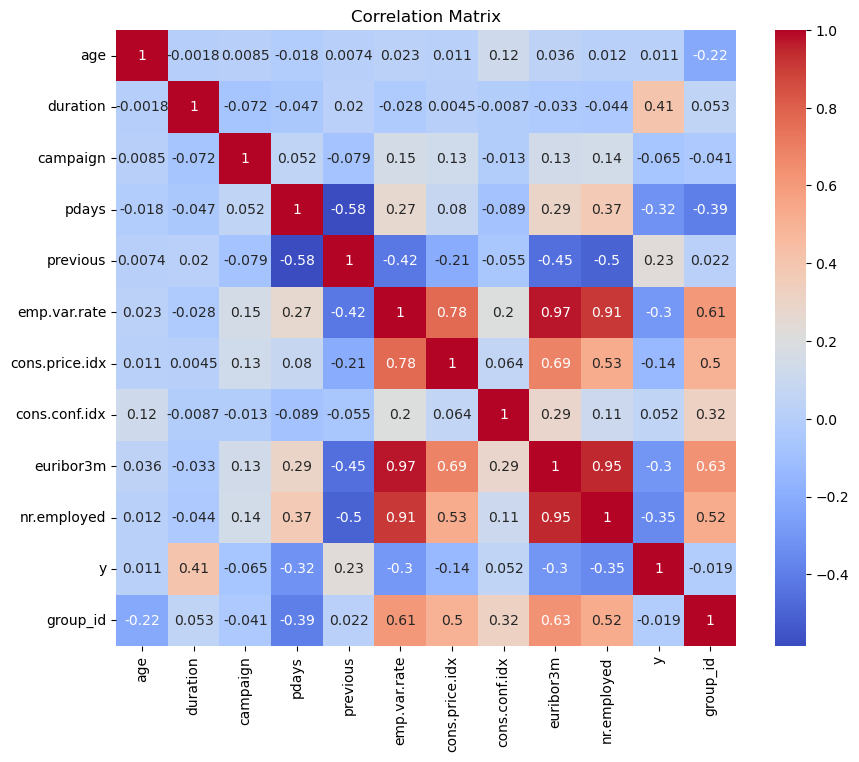

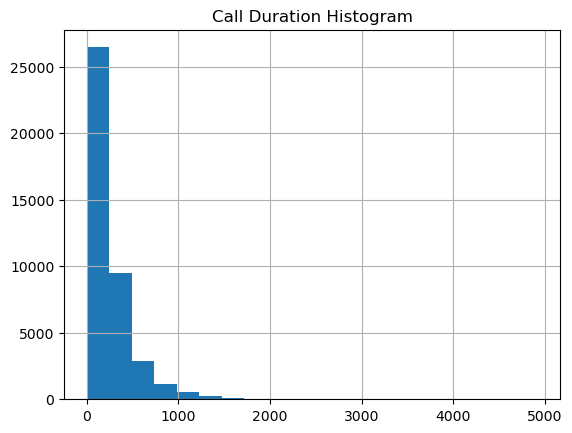

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
# checking how different numbers correlate
# plotting a heatmap
plt.figure(figsize=(10,8))
# calculating correlation only on numeric columns
sns.heatmap(bank_data.select_dtypes(include='number').corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

# also checking duration of calls
bank_data['duration'].hist(bins=20)
plt.title("Call Duration Histogram")
plt.show()

### Final Thoughts

I tested Logistic Regression, KNN, and Random Forest.
Random Forest worked the best.
I also used clustering to make a new feature called `group_id`.
The tuning helped a little bit but the default Random Forest was already pretty good.